In [1]:
import pickle
import pandas as pd
from rank_bm25 import BM25Okapi

# 加载ner_map
with open('ner_map.pkl', 'rb') as f:
    ner_map = pickle.load(f)

# 加载处理后的DataFrame
claims_df = pd.read_pickle("processed_claims_df.pkl")
evidence_df = pd.read_pickle("processed_evidence_df.pkl")

# 加载令牌列表
with open('tokens.pkl', 'rb') as f:
    tokens = pickle.load(f)

# 重新初始化BM25模型
bm25 = BM25Okapi(tokens)

# 现在可以调整BM25的参数，比如k1


In [11]:
import json
import pandas as pd
import re   
from nltk.tokenize import word_tokenize
import spacy

# 加载开发集数据
dev_claim_file_path = "data/dev-claims.json"
with open(dev_claim_file_path, "r") as file:
    dev_claims_data = json.load(file)

dev_claims = []
for claim_id, details in dev_claims_data.items():
    dev_claims.append({'claim_id': claim_id, **details})
dev_claims_df = pd.DataFrame(dev_claims)

def filter_text(text):
    """保留英文单词和特定模式（如化学符号、数字与字母的组合等）"""
    pattern = re.compile(r'\b[a-zA-Z0-9]+\b')  # 识别字母和数字的组合
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if pattern.match(token)]
    return " ".join(filtered_tokens)
# 应用文本过滤函数到正确的列
dev_claims_df['claim_text'] = dev_claims_df['claim_text'].apply(filter_text)


In [12]:
# 函数：根据声明文本和实体获取相关性最高的N条证据
def get_top_n_evidence(claim_text, entities, top_n=20):
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [evidence_df.iloc[i]['evidence_id'] for i in top_indexes]

def tokenize_with_entities(text, entities):
    """使用Spacy进行分词，并对实体进行加权处理"""
    doc = nlp(text)
    words = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    # 增加实体的出现次数
    words.extend([entity.lower() for entity in entities for _ in range(3)])  # 实体权重增加，出现3次
    return words
nlp = spacy.load("en_core_web_sm")

# 检索证据并计算准确率
correct_hits = 0
total_queries = 0

for index, row in dev_claims_df.iterrows():
    predicted_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []))
    actual_evidences = row['evidences']
    # 计算交集的大小
    correct_hits += len(set(predicted_evidences) & set(actual_evidences))
    total_queries += 1

# 计算平均准确率
if total_queries > 0:
    accuracy = correct_hits / total_queries
else:
    accuracy = 0

print(f"Top N Accuracy: {accuracy:.4f}")


Top N Accuracy: 1.0130


In [13]:
def get_top_n_evidence(claim_text, entities, top_n=20):
    # 为声明文本和相关实体构建查询令牌
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [evidence_df.iloc[i]['evidence_id'] for i in top_indexes]

# 检索证据并计算准确率
correct_hits = 0
total_evidences = 0

for index, row in dev_claims_df.iterrows():
    predicted_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []))
    actual_evidences = row['evidences']
    correct_hits += len(set(predicted_evidences) & set(actual_evidences))
    total_evidences += len(actual_evidences)

accuracy = correct_hits / total_evidences
print(f"Accuracy: {accuracy}")


Accuracy: 0.31771894093686354


In [20]:
from rank_bm25 import BM25Okapi

# 初始化BM25模型
bm25 = BM25Okapi(tokens, k1=0.7, b=0.3)  # 设置k1为1.0，b为0.75



In [21]:
def get_top_n_evidence(claim_text, entities, top_n=200):
    # 为声明文本和相关实体构建查询令牌
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [evidence_df.iloc[i]['evidence_id'] for i in top_indexes]

# 存储不同Top N的正确命中数和证据总数
top_n_values = [20, 50, 100, 200]
correct_hits = {n: 0 for n in top_n_values}
total_evidences = 0

for index, row in dev_claims_df.iterrows():
    all_predicted_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max(top_n_values))
    actual_evidences = set(row['evidences'])
    total_evidences += len(actual_evidences)

    for n in top_n_values:
        predicted_evidences_n = set(all_predicted_evidences[:n])
        correct_hits[n] += len(predicted_evidences_n & actual_evidences)

# 计算并打印各个Top N的准确率（召回率）
for n in top_n_values:
    if total_evidences > 0:
        recall = correct_hits[n] / total_evidences
    else:
        recall = 0
    print(f"Recall at Top {n}: {recall:.4f}")


Recall at Top 20: 0.3096
Recall at Top 50: 0.4338
Recall at Top 100: 0.5092
Recall at Top 200: 0.5621


In [23]:
import pandas as pd
import numpy as np
from rank_bm25 import BM25Okapi

k1_values = np.arange(0.3, 1.8, 0.2)  # 从0.5到1.7，步长为0.2
top_n_values = [3, 4, 5, 20, 50, 100, 200]
results = []

for k1 in k1_values:
    # 初始化BM25模型，每次循环更改k1
    bm25 = BM25Okapi(tokens, k1=k1, b=0.5)

    # 初始化存储命中数和证据总数的字典
    correct_hits = {n: 0 for n in top_n_values}
    total_evidences = 0

    # 遍历所有声明，计算各Top N的命中情况
    for index, row in dev_claims_df.iterrows():
        all_predicted_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max(top_n_values))
        actual_evidences = set(row['evidences'])
        total_evidences += len(actual_evidences)

        for n in top_n_values:
            predicted_evidences_n = set(all_predicted_evidences[:n])
            correct_hits[n] += len(predicted_evidences_n & actual_evidences)

    # 收集结果
    for n in top_n_values:
        recall = correct_hits[n] / total_evidences if total_evidences > 0 else 0
        results.append({
            'k1': k1,
            'Top N': n,
            'Recall': recall
        })

# 将结果保存为DataFrame，然后导出到CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv('bm25_recall_results.csv', index=False)


In [24]:
import pandas as pd
from rank_bm25 import BM25Okapi

# 参数组合
k1_values = [0.6, 0.8, 1.0]
b_values = [0.4, 0.5, 0.6]
top_n_values = [3, 4, 5, 20, 50, 100, 200]
results = []

# 运行BM25模型并收集结果
for k1 in k1_values:
    for b in b_values:
        bm25 = BM25Okapi(tokens, k1=k1, b=b)

        # 初始化存储命中数和证据总数的字典
        correct_hits = {n: 0 for n in top_n_values}
        total_evidences = 0

        # 遍历所有声明，计算各Top N的命中情况
        for index, row in dev_claims_df.iterrows():
            all_predicted_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max(top_n_values))
            actual_evidences = set(row['evidences'])
            total_evidences += len(actual_evidences)

            for n in top_n_values:
                predicted_evidences_n = set(all_predicted_evidences[:n])
                correct_hits[n] += len(predicted_evidences_n & actual_evidences)

        # 收集结果
        for n in top_n_values:
            recall = correct_hits[n] / total_evidences if total_evidences > 0 else 0
            results.append({
                'k1': k1,
                'b': b,
                'Top N': n,
                'Recall': recall
            })

# 将结果保存为DataFrame，然后导出到CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv('bm25_parameter_test_results.csv', index=False)


In [30]:
from rank_bm25 import BM25Okapi
import pandas as pd

# 确保BM25模型和必要的DataFrame已经正确加载
# 初始化BM25模型
bm25 = BM25Okapi(tokens, k1=0.6, b=0.6)

def get_top_n_evidence(claim_text, entities, top_n):
    # 为声明文本和相关实体构建查询令牌
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [(evidence_df.iloc[i]['evidence_id'], evidence_df.iloc[i]['text']) for i in top_indexes]

# 设置Top N值列表，使用最大值进行一次检索
top_n_values = [5, 20, 50, 100]
max_top_n = max(top_n_values)

# 对claims进行处理，一次检索最大的Top N值
results = {n: [] for n in top_n_values}
for index, row in claims_df.iterrows():
    top_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max_top_n)
    for n in top_n_values:
        for ev_id, ev_text in top_evidences[:n]:
            results[n].append({
                'claim_id': row['claim_id'],
                'claim_text': row['claim_text'],
                'evidence_id': ev_id,
                'evidence_text': ev_text
            })

# 为每个Top N创建DataFrame并保存为CSV
for n in top_n_values:
    results_df = pd.DataFrame(results[n])
    results_df.to_csv(f'training_data_top_{n}_evidences.csv', index=False)

print("All files saved successfully.")


All files saved successfully.


In [31]:
from rank_bm25 import BM25Okapi
import pandas as pd

# 确保BM25模型和必要的DataFrame已经正确加载
# 初始化BM25模型
bm25 = BM25Okapi(tokens, k1=0.6, b=0.6)

def get_top_n_evidence(claim_text, entities, top_n):
    # 为声明文本和相关实体构建查询令牌
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [(evidence_df.iloc[i]['evidence_id'], evidence_df.iloc[i]['text']) for i in top_indexes]

# 设置Top N值列表，使用最大值进行一次检索
top_n_values = [3, 4, 5, 20, 50, 100]
max_top_n = max(top_n_values)

# 对claims进行处理，一次检索最大的Top N值
results = {n: [] for n in top_n_values}
for index, row in dev_claims_df.iterrows():
    top_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max_top_n)
    for n in top_n_values:
        for ev_id, ev_text in top_evidences[:n]:
            results[n].append({
                'claim_id': row['claim_id'],
                'claim_text': row['claim_text'],
                'evidence_id': ev_id,
                'evidence_text': ev_text
            })

# 为每个Top N创建DataFrame并保存为CSV
for n in top_n_values:
    results_df = pd.DataFrame(results[n])
    results_df.to_csv(f'data/dev_top/training_data_top_{n}_evidences.csv', index=False)

print("All dev evidences prediction files saved successfully.")


All dev evidences prediction files saved successfully.


In [32]:
from rank_bm25 import BM25Okapi
import pandas as pd

# 读取processed_test_claims_df.pkl
test_claims_df = pd.read_pickle("processed_test_claims_df.pkl")

# 确保BM25模型和必要的DataFrame已经正确加载
# 初始化BM25模型
bm25 = BM25Okapi(tokens, k1=0.6, b=0.6)

def get_top_n_evidence(claim_text, entities, top_n):
    # 为声明文本和相关实体构建查询令牌
    claim_tokens = tokenize_with_entities(claim_text, entities)
    scores = bm25.get_scores(claim_tokens)
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return [(evidence_df.iloc[i]['evidence_id'], evidence_df.iloc[i]['text']) for i in top_indexes]

# 设置Top N值列表，使用最大值进行一次检索
top_n_values = [3, 4, 5, 20, 50, 100]
max_top_n = max(top_n_values)

# 对claims进行处理，一次检索最大的Top N值
results = {n: [] for n in top_n_values}
for index, row in test_claims_df.iterrows():
    top_evidences = get_top_n_evidence(row['claim_text'], row.get('entities', []), max_top_n)
    for n in top_n_values:
        for ev_id, ev_text in top_evidences[:n]:
            results[n].append({
                'claim_id': row['claim_id'],
                'claim_text': row['claim_text'],
                'evidence_id': ev_id,
                'evidence_text': ev_text
            })

# 为每个Top N创建DataFrame并保存为CSV
for n in top_n_values:
    results_df = pd.DataFrame(results[n])
    results_df.to_csv(f'data/test_top/training_data_top_{n}_evidences.csv', index=False)

print("All test evidences prediction files saved successfully.")


All test evidences prediction files saved successfully.


In [43]:
# 读取保存的训练集Top N证据文件,并为其添加标签
import pandas as pd
import numpy as np

# 读取Top N证据文件
top_n_values = [3, 4, 5, 20, 50, 100]
top_n_files = [f'data/test_top/test_data_top_{n}_evidences.csv' for n in top_n_values]
top_n_dfs = [pd.read_csv(file) for file in top_n_files]

# 读取claims_df.pkl
#claims_df = pd.read_pickle("processed_claims_df.pkl")

# 为每个Top N的证据文件添加标签保存到原有文件夹
for n, df in zip(top_n_values, top_n_dfs):
    # 设置空的标签列
    df['label'] = np.nan
    # 保存到原有文件夹
    df.to_csv(f'data/test_top/test_data_top_{n}_evidences.csv', index=False)
    
print("All files saved successfully.")

All files saved successfully.


In [28]:
import pandas as pd

# 假设 results_df 已经包含 k1, b, Top N 和 Recall 列
# 计算 Precision
results_df['Precision'] = results_df.apply(lambda row: (row['Recall'] * 3.35) / row['Top N'], axis=1)

# 计算 F-score
results_df['F-score'] = 2 * (results_df['Precision'] * results_df['Recall']) / (results_df['Precision'] + results_df['Recall'])

# 排序结果，按 F-score 降序排列
sorted_df = results_df.sort_values(by='F-score', ascending=False)

# 打印排序后的结果
for index, row in sorted_df.iterrows():
    print(f"k1 = {row['k1']}, b = {row['b']}, Top N = {row['Top N']}, Recall = {row['Recall']:.4f}, Precision = {row['Precision']:.4f}, F-score = {row['F-score']:.4f}")


k1 = 0.6, b = 0.6, Top N = 3.0, Recall = 0.1405, Precision = 0.1569, F-score = 0.1483
k1 = 0.6, b = 0.6, Top N = 4.0, Recall = 0.1609, Precision = 0.1348, F-score = 0.1467
k1 = 1.0, b = 0.5, Top N = 3.0, Recall = 0.1385, Precision = 0.1547, F-score = 0.1461
k1 = 0.8, b = 0.5, Top N = 3.0, Recall = 0.1385, Precision = 0.1547, F-score = 0.1461
k1 = 0.8, b = 0.6, Top N = 3.0, Recall = 0.1365, Precision = 0.1524, F-score = 0.1440
k1 = 0.6, b = 0.5, Top N = 4.0, Recall = 0.1568, Precision = 0.1313, F-score = 0.1430
k1 = 1.0, b = 0.5, Top N = 4.0, Recall = 0.1568, Precision = 0.1313, F-score = 0.1430
k1 = 0.6, b = 0.5, Top N = 5.0, Recall = 0.1772, Precision = 0.1187, F-score = 0.1422
k1 = 1.0, b = 0.6, Top N = 3.0, Recall = 0.1344, Precision = 0.1501, F-score = 0.1418
k1 = 0.6, b = 0.4, Top N = 4.0, Recall = 0.1548, Precision = 0.1296, F-score = 0.1411
k1 = 0.8, b = 0.6, Top N = 4.0, Recall = 0.1548, Precision = 0.1296, F-score = 0.1411
k1 = 1.0, b = 0.6, Top N = 4.0, Recall = 0.1527, Preci

count    1.208827e+06
mean     1.928637e+01
std      1.002182e+01
min      0.000000e+00
25%      1.200000e+01
50%      1.700000e+01
75%      2.400000e+01
max      4.390000e+02
Name: doc_length, dtype: float64


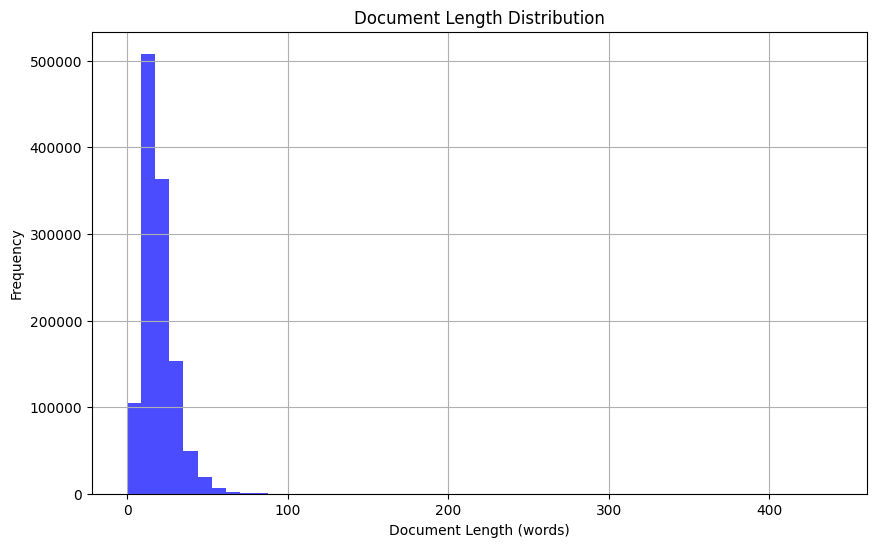

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设您的证据DataFrame是这样的
# evidence_df = pd.DataFrame({'text': [...]})

# 计算每个证据文档的词数
evidence_df['doc_length'] = evidence_df['text'].apply(lambda x: len(x.split()))

# 查看文档长度的描述统计
print(evidence_df['doc_length'].describe())

# 绘制文档长度的直方图
plt.figure(figsize=(10, 6))
plt.hist(evidence_df['doc_length'], bins=50, color='blue', alpha=0.7)
plt.title('Document Length Distribution')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
